In [2]:
import requests
import json
import random
from collections import namedtuple
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mplfinance as mpf

pd.set_option('display.max_columns', None)

headers = {
    'Referer': 'http://quote.eastmoney.com/',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'
}
%matplotlib inline

In [6]:
df = pd.read_csv('../material/binance-toy-data.csv', parse_dates=['time'])
df = df.set_index('time', drop=True)

df.index = pd.to_datetime(df.index)
# df.index.name = 'Date'
df = df.groupby(pd.Grouper(freq='H')).agg(dict(open='first', high='max', low='min', close='last', volume='sum'))

In [7]:
df

,open,high,low,close,volume
time,,,,,
2019-10-10 18:00:00,17.3120,17.3734,17.2873,17.3727,19063.12
2019-10-10 19:00:00,17.3726,17.4049,17.2701,17.3781,46482.40
2019-10-10 20:00:00,17.3830,17.7000,17.3559,17.5629,127617.73
2019-10-10 21:00:00,17.5548,17.6900,16.7966,17.0431,229397.12
2019-10-10 22:00:00,17.0559,17.0559,16.7519,16.8596,103099.55
...,...,...,...,...,...
2019-11-11 06:00:00,20.2419,20.2705,19.9000,20.0099,77870.99
2019-11-11 07:00:00,20.0099,20.1169,19.9387,20.0821,25621.92
2019-11-11 08:00:00,20.0729,20.1391,19.9891,20.0428,19527.84


/ide/workspace/lib/mplfinance/_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


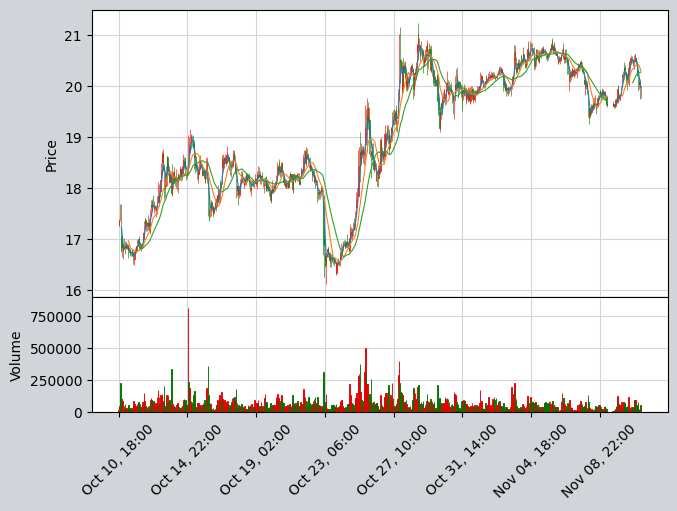

In [8]:
my_color = mpf.make_marketcolors(up='r', down='g', edge='inherit', wick='inherit', volume='inherit')
# 设置图表的背景色
my_style = mpf.make_mpf_style(marketcolors=my_color, figcolor='(0.82, 0.83, 0.85)', gridcolor='(0.82, 0.83, 0.85)')

mpf.plot(df, style=my_style, mav=(5, 15, 30), type='candle', volume=True)

plt.show()

In [3]:
Deal = namedtuple("Deal", ["code", "date", "operation", "amount", "price", "fee", "total"])

class Account:
    
    def __init__(self, uid, unit=100, fee_rate=2.5e-4):
        self.uid = uid
        self._cash = 0

        # Hold Position
        self.holds = {}
        # List of deals
        self.deals = []
        # The minimum amount of one transaction
        self.unit = unit
        # Commission on a transaction, both buy and sell operation need commission.
        self.fee_rate = fee_rate
    
    def __repr__(self):
        s = f'{self.__class__.__name__}(cash={self.cash:.2f}, value={self.value:.2f}, profit={self.profit:.2f})'
        return s

    @property
    def cash(self):
        return self._cash

    @cash.setter
    def cash(self, value):
        assert isinstance(value, (int, float)) and value >= 0.0
        self._cash = value

    def withdraw(self, amount):
        assert isinstance(amount, (int, float)) and amount >= 0.0
        if self.cash >= amount:
            self.cash -= amount
            return True
        else:
            return False
    
    def deposit(self, amount):
        assert isinstance(amount, (int, float)) and amount >= 0.0
        self.cash += amount
        return True
    @property
    def holdings(self):
        return sum(item["amount"] for _, item in self.holds.items())
    @property
    def value(self):
        return sum(item["amount"] * item["price"] for _, item in self.holds.items())
    @property
    def cost(self):
        return sum(item["cost"] for _, item in self.holds.items())
    @property
    def captial(self):
        return self.cash + self.value
    @property
    def profit(self):
        return self.value - self.cost
    @property
    def balance(self):
        return self.cash + self.value - self.cost

    def assets(self):
        print(30*"=")
        print(f"{'Type':10s}|{'Amount':>8s}|{'Value':>10s}")
        print(30*"-")
        print(f"{'Cash':10s}|{'--':>8s}|{self.cash:10.2f}")
        for code, item in self.holds.items():
            print(f"{code:10s}|{item['amount']:8d}|{item['amount']*item['price']:10.2f}")
        print(30*"=")

    def transactions(self):
        print(76*"=")
        print(f"{'Date':20s}|{'Op':>6s}|{'Symbol':>10s}|{'Amount':>10s}|{'Price':>8s}|{'Fee':>8s}|{'Total':>8s}")
        print(76*"-")
        for deal in self.deals:
            print(f"{deal.date:20s}|{deal.operation:>6s}|{deal.code:>10s}|{deal.amount:>10d}|{deal.price:>8.2f}|{deal.fee:>8.2f}|{deal.total:>8.2f}")
        print(76*"=")

    def update(self, code, price):
        if code not in self.holds:
            return False
        else:
            self.holds[code]["price"] = price
            return True
    
    def updates(self, codes, prices):
        for code, price in zip(codes, prices):
            self.update(code, price)
    
    def ceil(self, amount):
        return int(amount//self.unit * self.unit)

    def buy(self, code, date, price, amount):
        assert amount > 0, "amount should greater than zero."
        amount = self.ceil(min(amount, int(self.cash//((1+self.fee_rate)*price))))

        if self.cash<=0 or amount<=0:
            return {'ok': False, 'msg': f'Insufficient balance.'}
        total = amount*price*(1+self.fee_rate)
        self.cash -= total
        self.deals.append(Deal(code, date, "buy", amount, price, self.fee_rate*amount*price, total))
        if code in self.holds:
            self.holds[code]["amount"] += amount
            self.holds[code]["cost"] += amount*price*(1+self.fee_rate)
        else:
            self.holds[code] = {
                "date": date,
                "amount": amount,
                "cost": amount*price*(1+self.fee_rate),
                "price": price,
            }
        return {'ok': True, 'msg': f'Buy {amount} {code} with {price:.2f}.'}

    def sell(self, code, date, price, amount):
        assert amount > 0, "amount should greater zero."
        if code not in self.holds:
            return {'ok': False, 'msg': f'No such {code} asset in position.'}
        amount = self.ceil(min(amount, self.holds[code]["amount"]))
        total = amount*price*(1-self.fee_rate)
        self.cash += total
        self.deals.append(Deal(code, date, "sell", amount, price, self.fee_rate*amount*price, total))

        amortized_cost = self.holds[code]["cost"]/self.holds[code]["amount"]
        profit = amount * (price*(1-self.fee_rate) - amortized_cost)

        self.holds[code]["cost"] -= amount*amortized_cost
        self.holds[code]["amount"] -= amount

        if self.holds[code]["amount"] <= 0:
            del self.holds[code]
        
        return {'ok': True, 'msg': f'Sell {amount} {code} with {price:.2f}, profit is {profit:.2f}.'}
    
    def order(self, side, *args, **kwargs):
        assert side in ['buy', 'sell']
        return getattr(self, side)(*args, **kwargs)
    
    def order_target_position(self, code, date, price, position):
        capital = self.cost + self.cash
        p = self.cost / capital
        amount = self.ceil(abs(p - position) * capital / price)
        if amount <= 0:
            return {'ok': False, 'msg': f'do nothing'}
        if p < position:
            # buy
            return self.buy(code, date, price, amount)
        elif p > position:
            # sell
            return self.sell(code, date, price, amount)
        else:
            return {'ok': False, 'msg': f'do nothing'}


In [4]:
bob = Account('2a184f')
bob.deposit(10000)
ret = bob.buy('000001', '2022-11-10', 3.1, 1000)
print(ret)
ret = bob.buy('000001', '2022-11-10', 3.1, 1000)
print(ret)

# bob.update('000001', 3.4)
ret = bob.sell('000001', '2022-11-11', 3.1, 1000)
print(ret)
ret = bob.order_target_position('000001', '2022-11-11', 3.1, 0.9)
print(ret)

print(bob)
bob.assets()
bob.transactions()

{'ok': True, 'msg': 'Buy 1000 000001 with 3.10.'}
{'ok': True, 'msg': 'Buy 1000 000001 with 3.10.'}
{'ok': True, 'msg': 'Sell 1000 000001 with 3.10, profit is -1.55.'}
{'ok': True, 'msg': 'Buy 1900 000001 with 3.10.'}
Account(cash=1006.20, value=8990.00, profit=-2.25)
Type      |  Amount|     Value
------------------------------
Cash      |      --|   1006.20
000001    |    2900|   8990.00
Date                |    Op|    Symbol|    Amount|   Price|     Fee|   Total
----------------------------------------------------------------------------
2022-11-10          |   buy|    000001|      1000|    3.10|    0.78| 3100.78
2022-11-10          |   buy|    000001|      1000|    3.10|    0.78| 3100.78
2022-11-11          |  sell|    000001|      1000|    3.10|    0.78| 3099.22
2022-11-11          |   buy|    000001|      1900|    3.10|    1.47| 5891.47


In [213]:
print(bob.profit)
bob.assets()
bob.transactions()


19.602374123105164
Type      |  Amount|     Value
------------------------------
Cash      |      --|   6672.06
000001    |    1100|   3546.11
Date                |    Op|    Symbol|    Amount|   Price|     Fee|   Total
----------------------------------------------------------------------------
2022-03-30          |   buy|    000001|       700|    3.24|    0.57| 2269.58
2022-03-30          |   buy|    000001|       400|    3.20|    0.32| 1279.59
2022-03-30          |   buy|    000001|       400|    3.12|    0.31| 1246.43
2022-03-30          |   buy|    000001|       400|    2.99|    0.30| 1194.76
2022-03-30          |   buy|    000001|       500|    2.92|    0.36| 1459.35
2022-03-30          |  sell|    000001|       300|    3.01|    0.23|  902.30
2022-03-30          |  sell|    000001|       500|    3.06|    0.38| 1530.70
2022-03-30          |   buy|    000001|       400|    3.01|    0.30| 1204.98
2022-03-30          |  sell|    000001|       300|    3.07|    0.23|  920.11
2022-03-30

In [10]:
class Api(object):

    def __init__(self, price=100, scale=0.1):
        self.price = price
        self.scale = scale
        self.count = 0

    def next(self):
        plus =  random.uniform(1, 10)
        if random.random() <= 0.50 :
            self.price += self.scale*plus
        else:
            self.price -= self.scale*plus
        
        return self.price


In [11]:
isclose = lambda x, y: abs(x-y) < 0.4

class Grid():
    def __init__(
        self, lower_price, upper_price, grid_quantity, invest_amount, take_profit_price, stop_loss_price, init_holding=None, grid_mode='arithmetic'
    ):
        assert isinstance(grid_quantity, int) and grid_quantity %2 == 0
        self.invest_amount = invest_amount
        self._grids = np.linspace(lower_price, upper_price, grid_quantity)
        self._init_holding = init_holding
        self._history = []
        self._last_operation = None
        self._account = None

    def __repr__(self):
        return str(self._grids.tolist())

    def __call__(self, price):
        return self.operate(price)

    def _nearest_grid(self, value):
        idx = (np.abs(self._grids - value)).argmin()
        return idx, self._grids[idx]
    
    def bind_account(self, account):
        self._account = account

    def operate(self, price):
        assert self._account is not None
        gird_level, grid_value = self._nearest_grid(price)
        side = 'none'
        amount = 0
        if self._last_operation is None:
            side = 'buy'
            if self._init_holding is not None:
                amount = self._init_holding
            else:
                amount =  (len(self._grids) - np.searchsorted(self._grids, price)) * self.invest_amount
        else:
            if gird_level < self._last_operation['level']:
                if self._account.cash > 0 and price < grid_value:
                    side = 'buy'
                    amount = self.invest_amount
            elif gird_level > self._last_operation['level']:
                if self._account.holdings > 0 and price > grid_value:
                    side = 'sell'
                    amount = self.invest_amount
            else:
                pass
        
        if side != 'none':
            self._last_operation = {'side': side, 'level': gird_level}            

        self._history.append(price)
        self._price = price
        return {'side': side, 'amount': amount, 'price': price}

In [12]:
api = Api(50, 0.1)
random.seed(5)
x = [api.next() for _ in range(1000)]

bob = Account('2a184f')
bob.deposit(100000)

strategy = Grid(
    lower_price = 35, upper_price= 65,
    grid_quantity=8, invest_amount= 100, 
    take_profit_price=3600, stop_loss_price=2800, 
)
strategy.bind_account(bob)

dates = []
prices = []
sides = []
balances = []
profits = []
captials = []
holdings = []
for i in range(1000):
    price = x[i]
    ret = strategy(price)
    
    if ret['side'] != 'none':
        dates.append(i)
        prices.append(price)
        sides.append(ret['side'])
        # print(ret)
        # side, code, date, price, amount
        ret = bob.order(ret['side'], 'toy', str(i), price, ret['amount'])
    bob.update('toy', price)
    balances.append(bob.balance)
    profits.append(bob.profit)
    captials.append(bob.captial)
    holdings.append(bob.holdings)


In [13]:
print(bob.profit)
print(bob.balance)

bob.assets()
bob.transactions()

-733.2055155444632
90567.26789622614
Type      |  Amount|     Value
------------------------------
Cash      |      --|  91300.47
toy       |     300|  15339.98
Date                |    Op|    Symbol|    Amount|   Price|     Fee|   Total
----------------------------------------------------------------------------
0                   |   buy|       toy|       400|   49.34|    4.93|19740.69
74                  |   buy|       toy|       100|   43.40|    1.08| 4340.94
85                  |   buy|       toy|       100|   38.67|    0.97| 3867.94
99                  |   buy|       toy|       100|   34.75|    0.87| 3475.48
131                 |  sell|       toy|       100|   39.86|    1.00| 3985.08
145                 |  sell|       toy|       100|   43.58|    1.09| 4356.55
220                 |  sell|       toy|       100|   48.27|    1.21| 4826.01
230                 |  sell|       toy|       100|   52.16|    1.30| 5215.12
280                 |  sell|       toy|       100|   56.56|    1.41| 

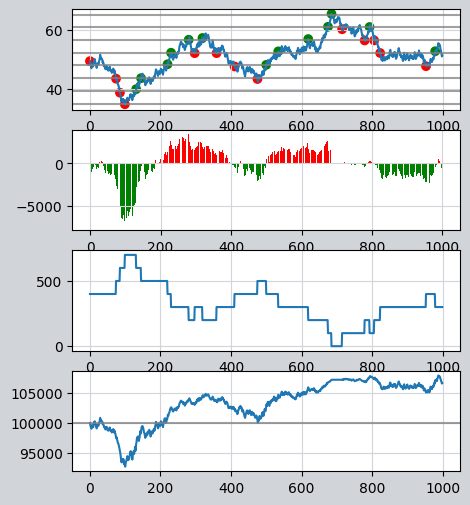

In [14]:
fig, axes = plt.subplots(4, 1, figsize=(5, 6))

axes[0].plot(x)
for i in strategy._grids:
    axes[0].axhline(i, color='gray', alpha=0.75)
axes[0].scatter(dates, prices, marker='o', color=['red' if op == 'buy' else 'green' for op in sides])


axes[1].bar(range(1000), profits, color=['red' if p >0 else 'green' for p in profits])
axes[2].plot(range(1000), holdings, color='C0')
axes[3].plot(captials)
axes[3].axhline(100000, color='gray', alpha=0.75)
# axes[3].plot(balances)

plt.show()

In [11]:
from pyecharts import options as opts
from pyecharts.charts import Kline
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
 
from pyecharts.globals import ThemeType

y_data = np.array(df[['open', 'close', 'low', 'high']]).tolist()
x_data = df.index.strftime("%Y-%m-%d %H:%M").values.tolist()

c = (
    Kline(init_opts=opts.InitOpts(width="1000px", height="600px", theme=ThemeType.DARK))
    .add_xaxis(x_data)
    .add_yaxis("kline", y_data)
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(is_scale=True),
        yaxis_opts=opts.AxisOpts(
            is_scale=True,
            splitarea_opts=opts.SplitAreaOpts(
                is_show=True, areastyle_opts=opts.AreaStyleOpts(opacity=1)
            ),
        ),
        datazoom_opts=[opts.DataZoomOpts(pos_bottom="-2%")],
        title_opts=opts.TitleOpts(title="Kline-DataZoom-slider-Position"),
    )
)
c.render_notebook()